# Social interaction: Neural correlates of ethogram interactions

Here we use the static, dynamic and transitive interactions ethogram that were build using dlc tracking for multianimal pose estimation and the ellipsoidal model for distance estimation. The definitions of interactions are based on ...paper.

We need infomation regarding: 

* ethogram
* alignment of spikes and point Fly camera
* spikes 

'August 23rd 2021'

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
import pandas as pd


In [194]:
ethogram_path = '/home/melisa/Documents/social_interaction_neural_activity/ethogram/'
tracking_path = '/home/melisa/Documents/social_interaction_neural_activity/tracking/'
spikes_path = '/home/melisa/Documents/social_interaction_neural_activity/spikes/'
figure_path = '/home/melisa/Documents/social_interaction_neural_activity/figures/'

static_e_filename = 'static_ethogram.npy'
tracking_filename = 'raw120sDLC_resnet50_social_interaction_labelmei19shuffle1_694000.csv'
spikes_filename = ['cluster_' +f'{i}' +'.npy' for i in range(10)]

static_ethogram = np.load(ethogram_path + static_e_filename)
stime_list = [np.load(spikes_path + spikes_filename[i]) for i in range(10)]
stime = [(stime_list[i] - stime_list[i][0])/1000 for i in range(10)]

tracking_data = pd.read_csv(tracking_path + tracking_filename)
tracking_data = tracking_data.to_numpy()

print(tracking_data.shape)
body_1 = tracking_data[3:,9*3+1:9*3+3].astype(np.float)
body_2 = tracking_data[3:,15*3+1:15*3+3].astype(np.float)

(3602, 52)


In [68]:
plt.plot(body_1[:,0],body_1[:3600,1])
plt.plot(body_2[:,0],body_2[:3600,1])

(5400, 9)


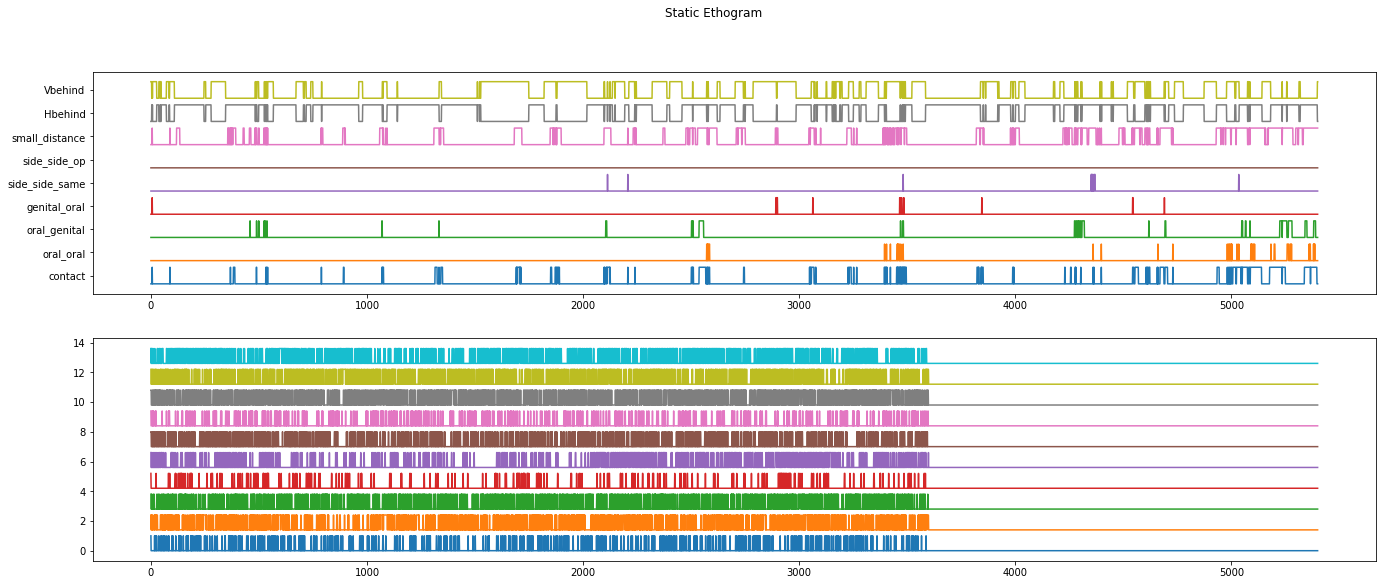

In [193]:
print(static_ethogram.shape)
fields_static=['contact', 'oral_oral', 'oral_genital','genital_oral','side_side_same','side_side_op','small_distance', 'Hbehind', 'Vbehind']
fig, ax = plt.subplots(2,1,figsize=(23, 9))
tickpos = [1.4*a for a in range(static_ethogram.shape[1])]
ax[0].plot(static_ethogram + tickpos);
ax[0].set_yticks(np.array(tickpos)+ 0.5)
ax[0].set_yticklabels(fields_static);
fig.suptitle('Static Ethogram')

spike_vector = np.zeros((5400,10))
for i in range(10):
    spike_vector[stime_ethogram[i],i] = 1

tickpos = [1.4*a for a in range(10)]
ax[1].plot(spike_vector + tickpos)

In [195]:
from scipy.ndimage import gaussian_filter
BINS = 50 
def occupancy_map(tracking = None, binnumber = BINS):
    
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    
    occupancy = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    data_points = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            occupancy [x1,y1]= occupancy[x1,y1] + 1
            data_points+=1
    occupancy = occupancy/data_points
    return occupancy

def neuron_activity_map(activity= None,tracking = None,binnumber = 70, neuronID = 0):
     
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    
    act_map = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    counter = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            act_map[x1,y1]+=np.mean(activity[neuronID,counter])
            counter+=1
        
    act_map = act_map/counter
    return act_map

def mean_activity_map(activity= None,tracking = None,binnumber = BINS):
    
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    act_map = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    counter = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            act_map[x1,y1]+=np.mean(activity[:,counter])
            counter+=1
        
    act_map = act_map/counter
    return act_map

In [196]:
stime_ethogram = [stime[i][np.where(stime[i] < 3599)].astype(int) for i in range(10)]
print(stime_ethogram[4])

[   0    4    9 ... 3585 3586 3598]


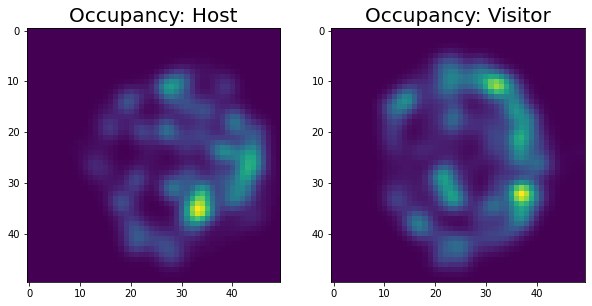

In [89]:
mouse = ['Host','Visitor']
sigma = 1.5
occupancy1 = occupancy_map(body_1.T)
occupancy1 = gaussian_filter(occupancy1, sigma)

occupancy2 = occupancy_map(body_2.T)
occupancy2 = gaussian_filter(occupancy2, sigma)

figure, axes = plt.subplots(1,2)
axes[0].imshow(occupancy1)
axes[1].imshow(occupancy2)
for i in range(2):
    axes[i].set_title('Occupancy: ' + mouse[i], fontsize = 20)

figure.set_size_inches(10,15)

Text(0.5, 0.98, 'Neural Activity')

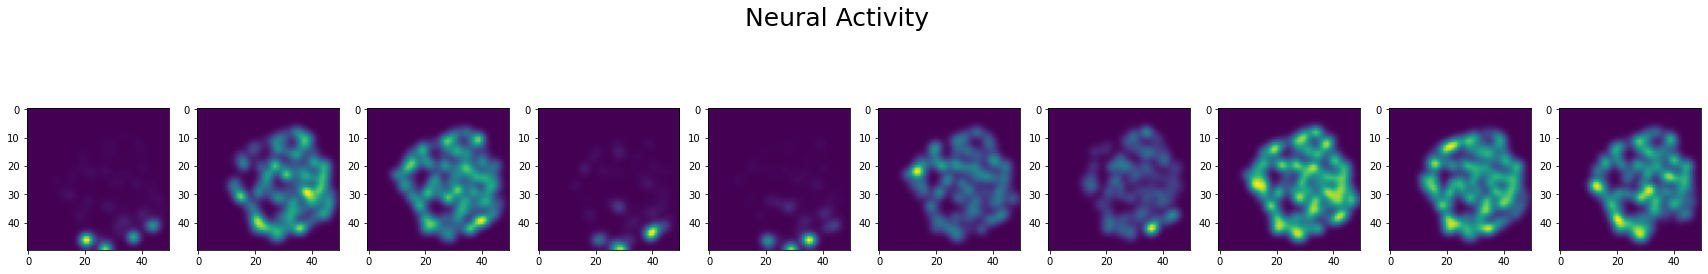

In [101]:
figure, axes = plt.subplots(1,10)

for neuron in range(len(stime_ethogram)):
    neuron_activity = occupancy_map(body_1[stime_ethogram[neuron],:].T)
    normalized_activity_map = np.zeros_like(neuron_activity)
    normalized_activity_map[np.where(occupancy1)] = neuron_activity[np.where(occupancy1)]/occupancy[np.where(occupancy1)]
    
    
    neuron_activity = gaussian_filter(normalized_activity_map,sigma)
    axes[neuron].imshow(neuron_activity)
    
figure.set_size_inches(30,5)   
figure.suptitle('Neural Activity', fontsize = 25)

Text(0.5, 0.98, 'Interaction Localization')

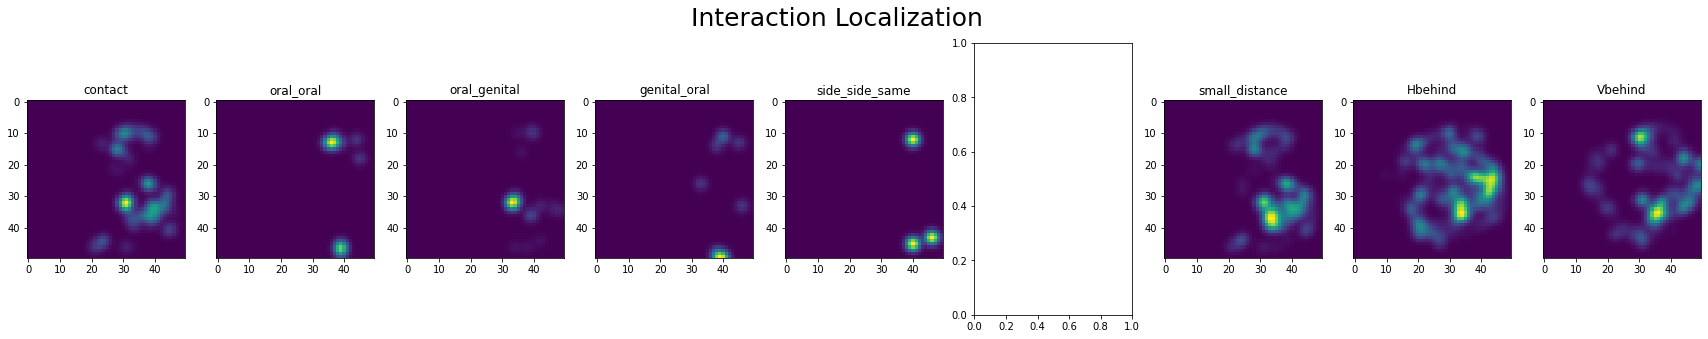

In [120]:
figure, axes = plt.subplots(1,static_ethogram.shape[1])
fields_static=['contact', 'oral_oral', 'oral_genital','genital_oral','side_side_same','side_side_op','small_distance', 'Hbehind', 'Vbehind']

for interaction in range(static_ethogram.shape[1]):
    if body_1[static_ethogram[0:3599,interaction],:].shape[0]:
        interaction_ocupancy = occupancy_map(body_1[static_ethogram[0:3599,interaction],:].T)
        interaction_ocupancy= gaussian_filter(interaction_ocupancy,sigma)
        axes[interaction].imshow(interaction_ocupancy)
        axes[interaction].set_title(fields_static[interaction])
figure.set_size_inches(30,5)   
figure.suptitle('Interaction Localization', fontsize = 25)

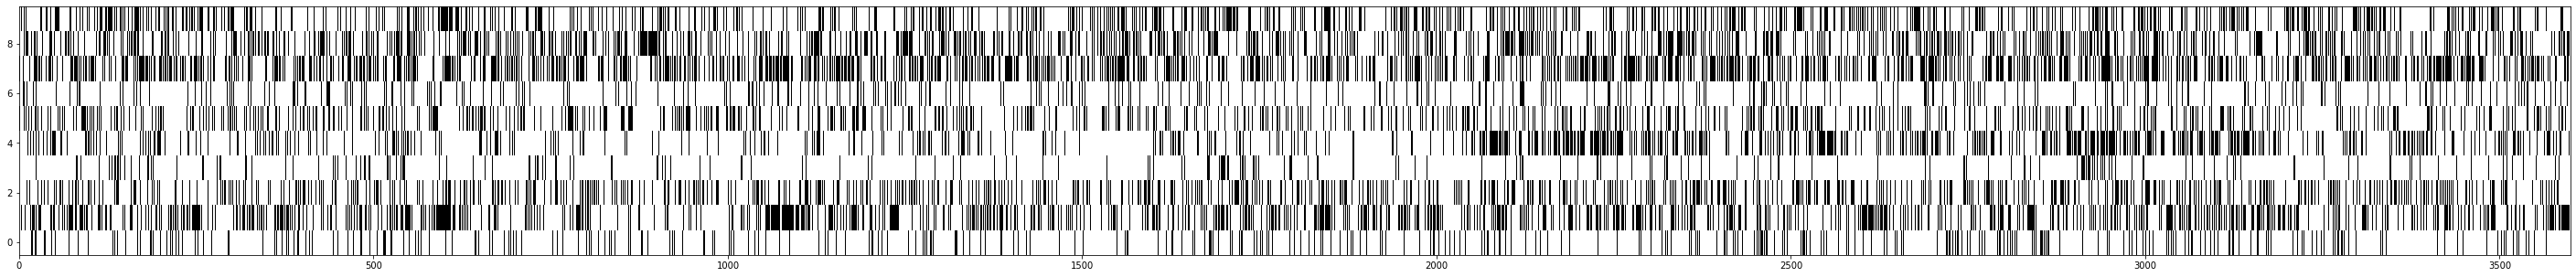

In [151]:
spikes_matrix = np.zeros((3600,10))
for neuron in range(10):
    spikes_matrix[stime_ethogram[neuron],neuron]=1

figure, axes = plt.subplots(figsize=(18, 20))
mesh = axes.pcolormesh(np.arange(0,3600),np.arange(0,10),spikes_matrix.T, cmap='Greys',shading='auto')
figure.set_size_inches(50,5)

In [157]:
np.where(np.diff(static_ethogram[:,1]))[0]

array([2571, 2572, 2575, 2576, 2577, 2579, 2583, 2585, 3394, 3395, 3403,
       3404, 3421, 3422, 3453, 3454, 3455, 3459, 3462, 3463, 3469, 3470,
       3480, 3481, 4359, 4360, 4397, 4398, 4659, 4660, 4728, 4729, 4980,
       4981, 4987, 4988, 4989, 4990, 4995, 4996, 4999, 5000, 5001, 5002,
       5025, 5026, 5033, 5034, 5089, 5091, 5092, 5095, 5100, 5102, 5106,
       5107, 5182, 5183, 5197, 5201, 5257, 5264, 5271, 5274, 5277, 5278,
       5359, 5360, 5363, 5365, 5379, 5380, 5381, 5382, 5384, 5386])

/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


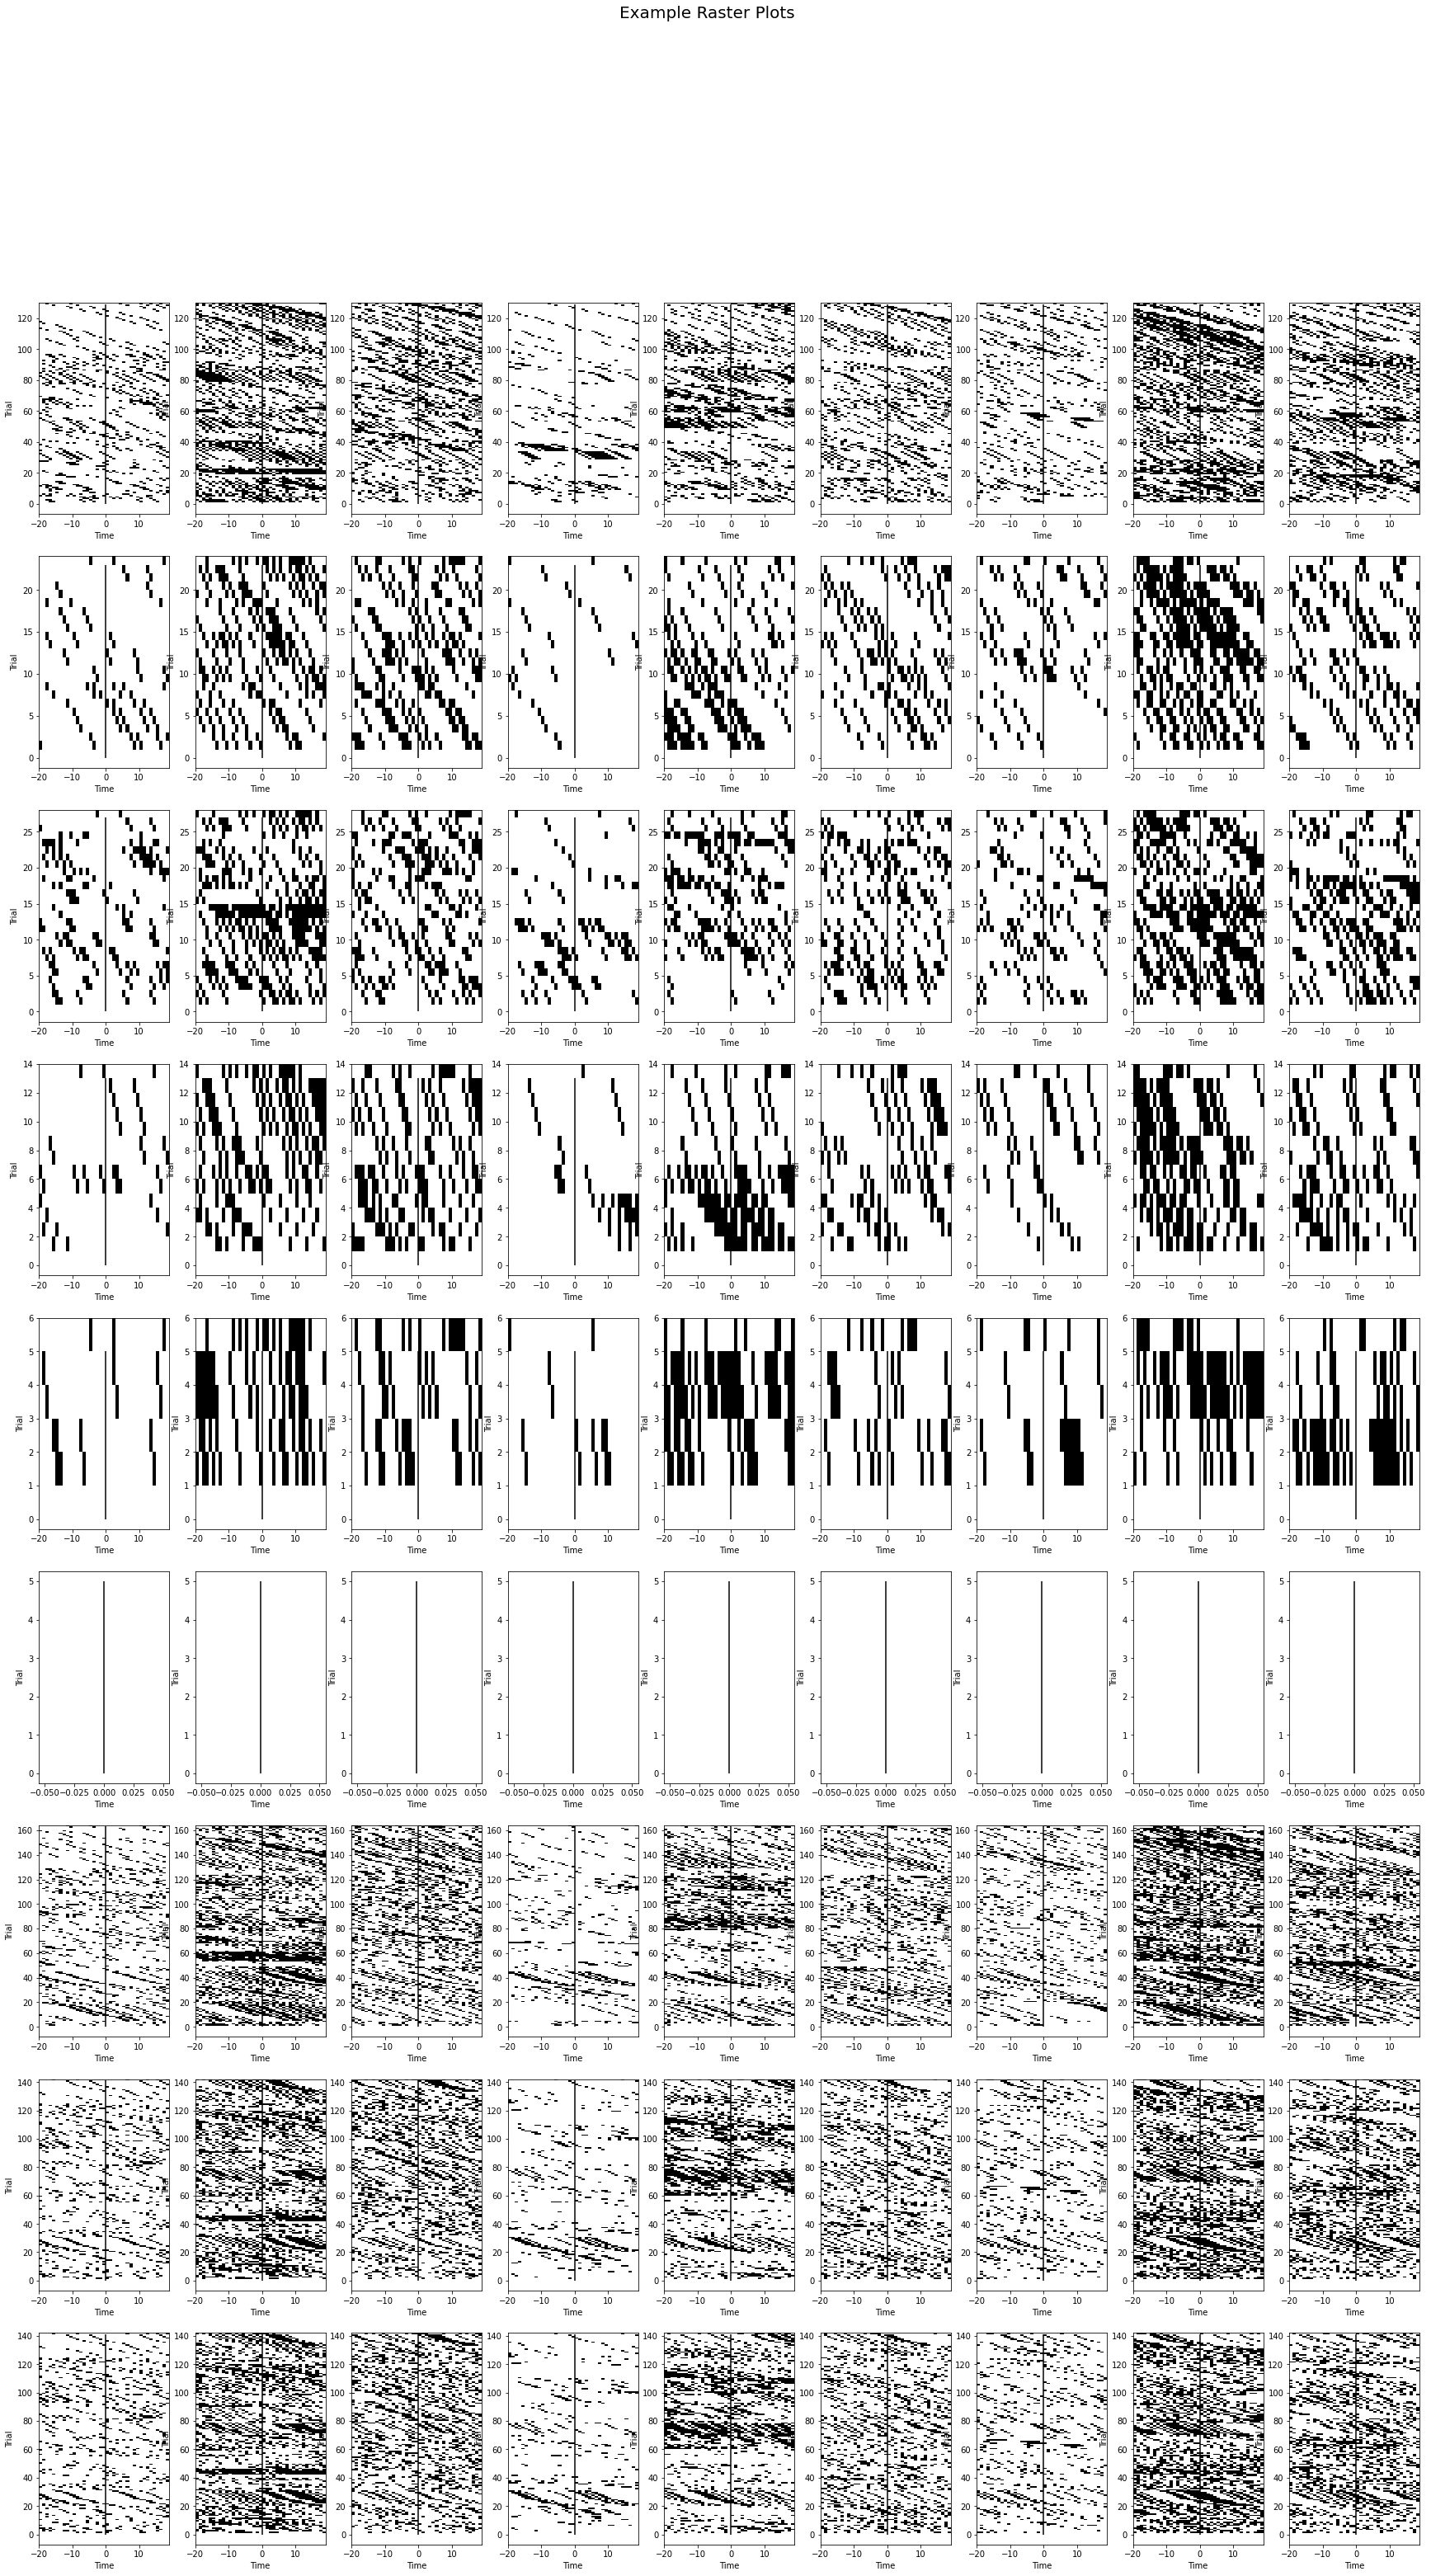

In [192]:
## create a list of events
figure , axes = plt.subplots(9,9)
neuron = 0
time = np.arange(-20,20)

for interactions in range(9):
    int_sp0 = np.where(np.diff(static_ethogram[0:3599,interactions]))[0]
    int_sp = int_sp0[np.logical_and(int_sp0>25,int_sp0<3550)]
    trials = np.arange(1,int_sp.shape[0]+1)
    for neuron in range(9):
        raster = np.zeros((int_sp.shape[0],40))
        for i in range(int_sp.shape[0]):
            raster[i,:] = spikes_matrix[int_sp[i]-20:int_sp[i]+20,neuron]
        if int_sp.shape[0]:
            mesh = axes[interactions,neuron].pcolormesh(time,trials,raster,cmap = 'Greys')
        axes[interactions,neuron].set_xlabel('Time')
        axes[interactions,neuron].set_ylabel('Trial')
        axes[interactions,neuron].vlines(0,0, i, color = 'k')

figure.set_size_inches(30,50)
figure.suptitle( 'Example Raster Plots'  , fontsize = 20)
figure_name = figure_path + 'example_raster_plot.png'
figure.savefig(figure_name)

In [139]:
n_spikes = np.zeros((10,9))
for a in range(static_ethogram.shape[1]):
    for i in range(10):
        if np.sum(np.where(static_ethogram[:,a])):
            n_spikes[i,a] = np.sum(np.logical_and(static_ethogram[:,a],spike_vector[:,i]))/np.sum(np.where(static_ethogram[:,a]))

firing_rate = [np.sum(spike_vector[:,i])/5400 for i in range(10)]

[0.14185185185185184, 0.34185185185185185, 0.2837037037037037, 0.07537037037037037, 0.2514814814814815, 0.2348148148148148, 0.1287037037037037, 0.41388888888888886, 0.3085185185185185, 0.2761111111111111]


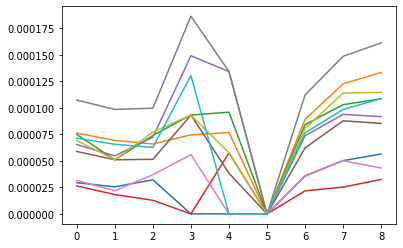

In [140]:
plt.plot(n_spikes.T)
print(firing_rate)